# Using the Surprise library

[Surprise](http://surpriselib.com/) is a Python scikit building and analyzing recommender systems that deal with explicit rating data. Its name stands for Simple Python RecommendatIon System Engine.

In [1]:
from surprise import KNNBasic
from surprise import SVD
from surprise import Dataset
from collections import defaultdict
from surprise import get_dataset_dir
from surprise.model_selection import train_test_split
import io
import time
import matplotlib.pyplot as plt
%matplotlib inline

Below we will create an SVD model using the 100k dataset from MovieLens. This takes a few seconds to run so be patient!

In [2]:

# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k') # there are a couple of famous Rec System datasets available in this library
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset() # Return a list of ratings that can be used as a testset
predictions = algo.test(testset)

In [5]:
# some examples of predictions
print(predictions[:5])

[Prediction(uid='196', iid='302', r_ui=3.52986, est=4.261726904081705, details={'was_impossible': False}), Prediction(uid='196', iid='377', r_ui=3.52986, est=2.779626499603194, details={'was_impossible': False}), Prediction(uid='196', iid='51', r_ui=3.52986, est=3.5185868946605665, details={'was_impossible': False}), Prediction(uid='196', iid='346', r_ui=3.52986, est=3.6546897854832348, details={'was_impossible': False}), Prediction(uid='196', iid='474', r_ui=3.52986, est=4.249149513494704, details={'was_impossible': False})]


## Some helper functions

We have built the predictions. Now we can visualize them. We first write these helpers functions.

In [6]:
from tmdb_class import TMDB # The class to retrive the movie poster images

def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Visualizing the recommendations

We can see for each user what are the top recommended movies.

In [8]:
top_n = get_top_n(predictions)
top_n['943']

[('114', 4.639253139063324),
 ('272', 4.586688462070978),
 ('178', 4.577128644063579),
 ('483', 4.450129334790051),
 ('169', 4.444367508925861),
 ('963', 4.4000679939409295),
 ('156', 4.385139371254366),
 ('480', 4.373013197382889),
 ('223', 4.360117208893587),
 ('199', 4.332008744542402)]

In [9]:
import re
from IPython.display import Image
from IPython.display import display, HTML

top_n = get_top_n(predictions, n=10)

# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Print the recommended items for user id 1
uid = '1'
user_ratings = top_n[uid]
recommended_items = [iid for (iid, _) in user_ratings]
print(uid, recommended_items)

# Convert ids into names.
item_names = [rid_to_name[rid]
              for rid in recommended_items]

print(uid, item_names)

for name in item_names:
    print(name)
    clean_name = re.sub(r'\([^)]*\)', '', name) # this remove the year of the movie which is in between paranthesis
    url = TMDB().get_poster_path_by_name(clean_name)
    print(url)
    if url:
        display(Image(url=url))

1 ['408', '483', '474', '357', '318', '480', '511', '285', '514', '1007']
1 ['Close Shave, A (1995)', 'Casablanca (1942)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', "One Flew Over the Cuckoo's Nest (1975)", "Schindler's List (1993)", 'North by Northwest (1959)', 'Lawrence of Arabia (1962)', 'Secrets & Lies (1996)', 'Annie Hall (1977)', 'Waiting for Guffman (1996)']
Close Shave, A (1995)
None
Casablanca (1942)
http://image.tmdb.org/t/p/w200/wOBKAoUJZb5qTsWv5XXvVV2vUzz.jpg


Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
http://image.tmdb.org/t/p/w200/tviJ68Wj4glQk3CPMvdvExYHxX.jpg


One Flew Over the Cuckoo's Nest (1975)
http://image.tmdb.org/t/p/w200/2Sns5oMb356JNdBHgBETjIpRYy9.jpg


Schindler's List (1993)
http://image.tmdb.org/t/p/w200/yPisjyLweCl1tbgwgtzBCNCBle.jpg


North by Northwest (1959)
http://image.tmdb.org/t/p/w200/aNV789h3oHm2pTHK5Bdq5RuiumZ.jpg


Lawrence of Arabia (1962)
http://image.tmdb.org/t/p/w200/nQbjWEbYWr3PaIWvOLVkOaBX4DG.jpg


Secrets & Lies (1996)
http://image.tmdb.org/t/p/w200/8uinoRlLK1wh2l7l7P2PqnuxRiS.jpg


Annie Hall (1977)
http://image.tmdb.org/t/p/w200/bK9bLXwxWuXX5mbq75PZqjvAtfG.jpg


Waiting for Guffman (1996)
http://image.tmdb.org/t/p/w200/4rjbIRSS5DZAmyMzCgKnsC89LOB.jpg


## Cross-validation using surprise
This package also provides for you built-in cross-validation to split the data to multiple folds.

In [10]:
from surprise.model_selection import cross_validate

algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True);

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9314  0.9447  0.9404  0.9311  0.9337  0.9363  0.0054  
Fit time          4.38    4.13    4.10    4.12    4.12    4.17    0.11    
Test time         0.24    0.22    0.22    0.23    0.22    0.22    0.01    


### User-based collaborative filtering with surprise!

In [11]:
from surprise import KNNWithMeans

sim_options = {
    'name': 'pearson', #let's use pearson similarity which can be seen as mean-centered cosine similarity
    'user_based': True #we will do user-based CF
}
knn_means = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

# Run 5-fold cross-validation and print results.
cross_validate(knn_means, data, measures=['RMSE'], cv=5, verbose=True);

Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9546  0.9577  0.9502  0.9502  0.9387  0.9503  0.0064  
Fit time          1.58    1.59    1.57    1.55    1.58    1.57    0.01    
Test time         3.16    3.12    3.14    3.17    3.18    3.15    0.02    


## Precision- Recall @k

In [12]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


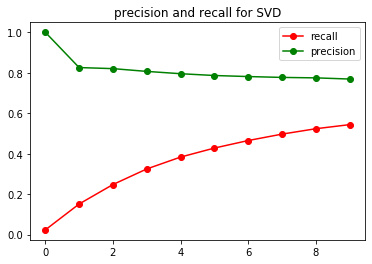

precision @ 20 for SVD 0.7464738933785767
recall @ 20 for SVD 0.648948064864878


In [13]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(10):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) # rating > 3 = relevant, rating < 3 = irrelevant

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

plt.plot(range(10), recall, 'ro-', label="recall")
plt.plot(range(10), precision, 'go-', label="precision")
plt.title("precision and recall for SVD")
plt.legend()
plt.show();

precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)

print("precision @ 20 for SVD", sum(prec for prec in precisions.values()) / len(precisions))
print("recall @ 20 for SVD", sum(rec for rec in recalls.values()) / len(recalls))


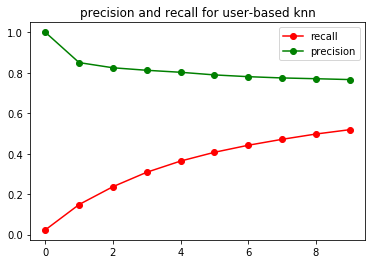

precision @ 20 for user-based knn 0.743469015340104
recall @ 20 for user-based knn 0.6332713162077663


In [14]:
algo = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(10):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) # rating > 3 = relevant, rating < 3 = irrelevant

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )


plt.plot(range(10), recall, 'ro-', label="recall")
plt.plot(range(10), precision, 'go-', label="precision")
plt.legend()
plt.title("precision and recall for user-based knn")
plt.show();

precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)

print("precision @ 20 for user-based knn", sum(prec for prec in precisions.values()) / len(precisions))
print("recall @ 20 for user-based knn", sum(rec for rec in recalls.values()) / len(recalls))

## precision-recall curve
We will now observe the area under precision recall curve for tow methods: SVD and KNN.

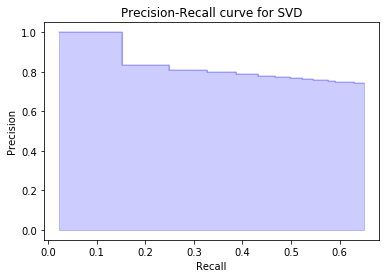

In [15]:
from inspect import signature

algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(20):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) 

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for SVD');

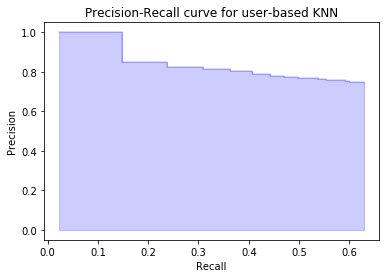

In [16]:
algo =  KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(20):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) 

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for user-based KNN');

## Tuning hyperr-parameters with surprise
As we saw we have built-in cross-validation in this package. We can use this to tune the hyper-parameters of our recommender system, eg tuning the number of neighbours in KNN or the number of factors (or the reduced dimensionality) in SVD.

In [17]:
from surprise.model_selection import GridSearchCV

In [18]:
SVD_grid_search = GridSearchCV(SVD, param_grid={'n_factors': [50, 100, 200, 300]}, measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)
SVD_grid_search.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   26.6s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   43.4s finished


In [19]:
print("best parameter:", SVD_grid_search.best_params)
print("best rmse: ", SVD_grid_search.best_score)
# you can even see the whole cv results
print("\n")
SVD_grid_search.cv_results

best parameter: {'rmse': {'n_factors': 50}}
best rmse:  {'rmse': 0.934150282024882}




{'split0_test_rmse': array([0.92919313, 0.93420735, 0.94101626, 0.94223897]),
 'split1_test_rmse': array([0.93433629, 0.93564695, 0.94135909, 0.94694603]),
 'split2_test_rmse': array([0.94384528, 0.9409202 , 0.94575799, 0.94959188]),
 'split3_test_rmse': array([0.93941775, 0.94136428, 0.94179999, 0.9473005 ]),
 'split4_test_rmse': array([0.92395894, 0.92767885, 0.93403353, 0.93282546]),
 'mean_test_rmse': array([0.93415028, 0.93596352, 0.94079337, 0.94378057]),
 'std_test_rmse': array([0.00707405, 0.00501113, 0.0037875 , 0.00597616]),
 'rank_test_rmse': array([1, 2, 3, 4]),
 'mean_fit_time': array([ 2.65849977,  4.25446105,  7.63755264, 12.31614447]),
 'std_fit_time': array([0.13431237, 0.10559521, 0.04500649, 0.1172346 ]),
 'mean_test_time': array([0.2438201 , 0.24539914, 0.26483588, 0.25924931]),
 'std_test_time': array([0.01219437, 0.01394729, 0.00488798, 0.01407351]),
 'params': [{'n_factors': 50},
  {'n_factors': 100},
  {'n_factors': 200},
  {'n_factors': 300}],
 'param_n_factors

Now for KNN

In [52]:
print(sim_options)

{'name': 'pearson', 'user_based': True}


In [54]:
KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid={'k': [20, 30, 40, 50], 
                                                         'sim_options': {'name': ['pearson'], 'user_based': [True]}}, 
                               measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)
KNN_grid_search.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   23.9s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   37.1s finished


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [55]:
print("best parameter:", KNN_grid_search.best_params)
print("best rmse: ", KNN_grid_search.best_score)
# you can even see the whole cv results
print("\n")
KNN_grid_search.cv_results

best parameter: {'rmse': {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': True}}}
best rmse:  {'rmse': 0.9495389757947457}




{'split0_test_rmse': array([0.96628175, 0.96051719, 0.95864725, 0.95797863]),
 'split1_test_rmse': array([0.95489787, 0.9481922 , 0.9461357 , 0.94476868]),
 'split2_test_rmse': array([0.95549887, 0.94895746, 0.94689389, 0.94593273]),
 'split3_test_rmse': array([0.95835789, 0.95209653, 0.95017564, 0.94946202]),
 'split4_test_rmse': array([0.95874484, 0.95305395, 0.95061274, 0.94955281]),
 'mean_test_rmse': array([0.95875624, 0.95256347, 0.95049305, 0.94953898]),
 'std_test_rmse': array([0.00405684, 0.00437794, 0.00443952, 0.0046259 ]),
 'rank_test_rmse': array([4, 3, 2, 1]),
 'mean_fit_time': array([1.50345488, 1.5440764 , 1.56165185, 1.52338228]),
 'std_fit_time': array([0.04457607, 0.08058297, 0.07987968, 0.09862941]),
 'mean_test_time': array([2.62045274, 2.8986362 , 3.18634043, 3.5256145 ]),
 'std_test_time': array([0.13073785, 0.07294217, 0.03138703, 0.19812655]),
 'params': [{'k': 20, 'sim_options': {'name': 'pearson', 'user_based': True}},
  {'k': 30, 'sim_options': {'name': 'pea

Let's save the best SVD model. We will use it later.

In [50]:
best_model_svd = SVD_grid_search.best_estimator['rmse']

In [54]:
import pickle
file_name = "best_model_svd"
pickle.dump(best_model_svd, open(file_name, 'wb'))

In [56]:
m = pickle.load(open("best_model_svd", 'rb'))
m.predict('6', '908')

Prediction(uid='6', iid='908', r_ui=None, est=2.3044446712435964, details={'was_impossible': False})